<a href="https://colab.research.google.com/github/oguz-bektas/Predictive-Maintenance/blob/master/Prognostic_Metrics_Remaining_Useful_Life_Estimation_of_Multi_Regime_Turbofan_Engines_through_Multi_Classifier_Data_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests, zipfile, io
import scipy.stats as stats

In [2]:
# Mirror link'den veri alinip local colab drive yuklenir
r = requests.get('https://data.nasa.gov/download/ff5v-kuh6/application%2Fzip')
# local drive linkindeki dosya unzip edilir, dosyalar icin yukardaki resme bakabilirsiniz
z = zipfile.ZipFile(io.BytesIO(r.content))






In [3]:
df_train =  pd.read_csv(z.open("train_FD002.txt"),  parse_dates=False,header=None, delimiter=" ")
# check the sensors below and transform the exponential decreasing ones to exp. inreasing ones
df_test =  pd.read_csv(z.open("test_FD002.txt"),  parse_dates=False,header=None, delimiter=" ")
df_rul =  pd.read_csv(z.open("RUL_FD002.txt"),  parse_dates=False,header=None, delimiter=" ")


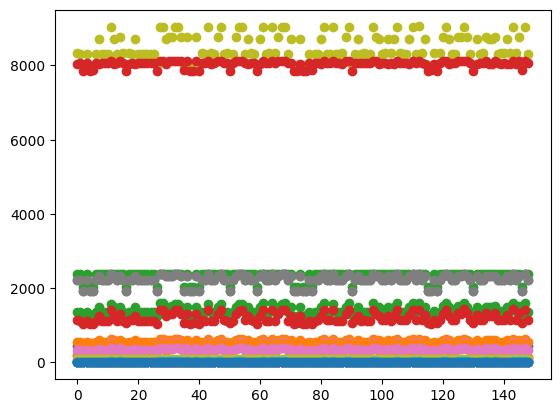

In [4]:
s_traj = df_train.iloc[:,5:-2] # sample trajectory - 1st traj of thte FD002 Train

for i in range(s_traj.shape[1]):
  s_traj.iloc[:149,i].plot(marker='o', linestyle='none')
  #plt.show()

In [5]:
ref_sensor = s_traj[5]
ref_sensor.unique()

array([449.44, 445.  , 462.54, 491.19, 518.67, 489.05])

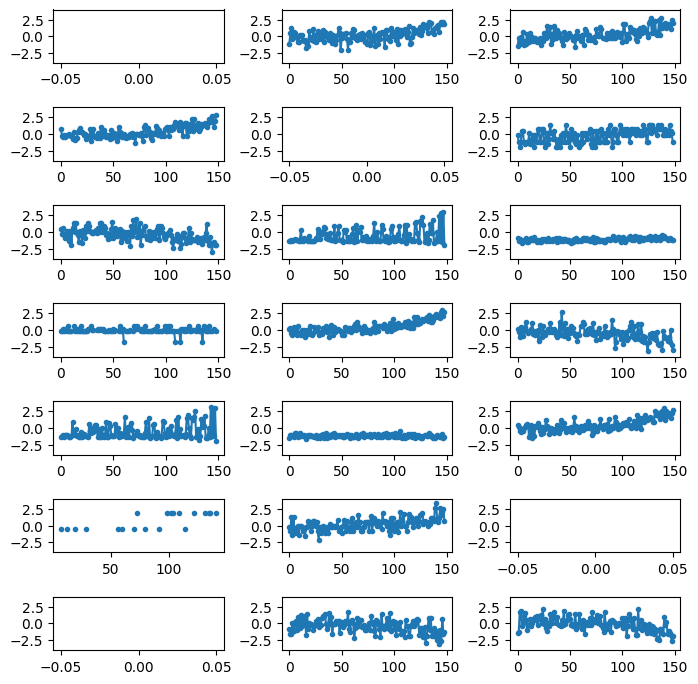

In [6]:
ref_sensor = s_traj[5]
s_traj_n = s_traj.copy()
figure, axis = plt.subplots(7, 3)
figure.set_figheight(7)
figure.set_figwidth(7)
figure.tight_layout()

for s in s_traj.columns:
  temp_sensor = s_traj[s].copy()
  for cl_value in ref_sensor.unique():
    cluster = np.where(ref_sensor == cl_value)[0]
    #plt.plot(z_score(temp_sensor[cluster]))
    temp_sensor[cluster] = stats.zscore(temp_sensor[cluster])
  s_traj_n[s]=temp_sensor
  axis[(s-5)//3, (s-5)%3].plot(temp_sensor[:149], marker='.' ) # first trajectory length = 149
# Defining custom  'ylim' values.
custom_ylim = (-4, 4)

# Setting the values for all axes.
plt.setp(axis, ylim=custom_ylim,)
plt.show()


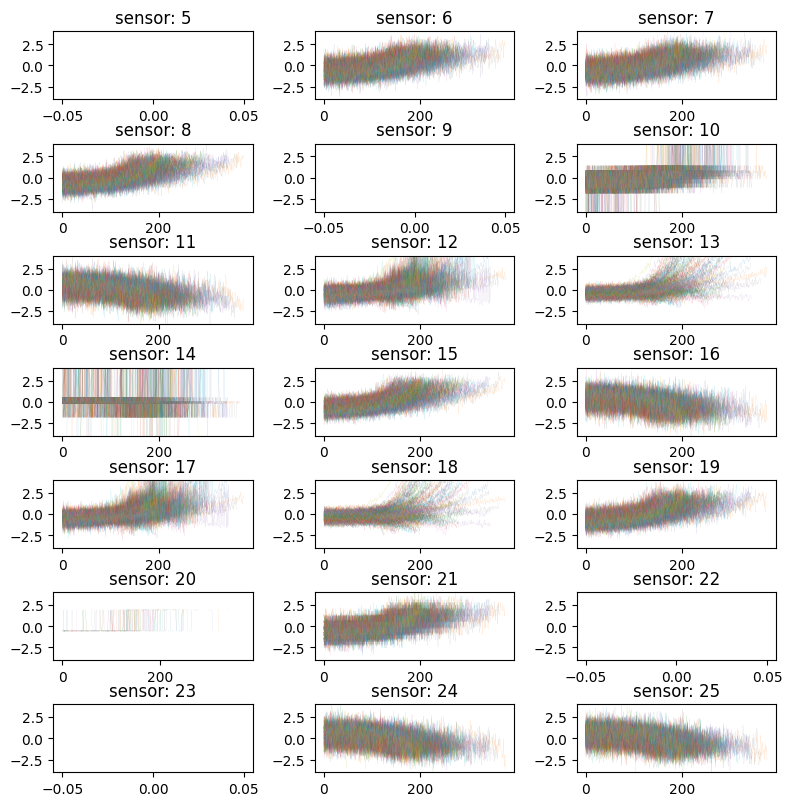

In [18]:
ref_traj = df_train[0]
figure, axis = plt.subplots(7, 3)
figure.set_figheight(8)
figure.set_figwidth(8)
figure.tight_layout()

for s in s_traj_n.columns:
  for t in ref_traj.unique():
    traj_cluster = np.where(ref_traj == t)[0]
    axis[(s-5)//3, (s-5)%3].plot(s_traj_n.iloc[traj_cluster,s-5].tolist(),linewidth=.05)# meaning of -5 => we deleted the unit num, cyle and op settings at the beginning
    axis[(s-5)//3, (s-5)%3].set_title(f"sensor: {s}")
# Defining custom  'ylim' values.
custom_ylim = (-4, 4)

# Setting the values for all axes.
plt.setp(axis, ylim=custom_ylim,)
plt.show()



sensors 6-7-8-11-15-16-19-21-24-25 are useful and sensor:24-25-11-16 need to be transformed

In [19]:
# Transforming 24-25-11-16
# Combining train and test

df_all = pd.concat([df_train, df_test])

# Subtracting the values to transform the decreasing sensors into increasing ones
for t in [24,25,11,16]:
  df_all[t] = (max(df_all[t])+1) - df_all[t]

df_train=df_all.iloc[:len(df_train)]
df_test=df_all.iloc[len(df_train):]


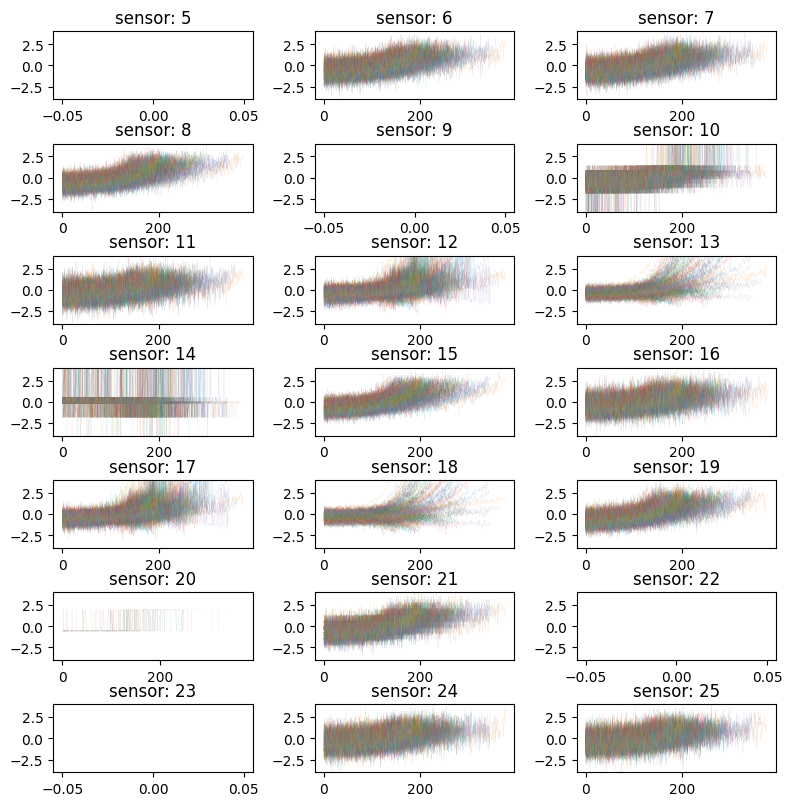

In [20]:
# Re-run. all decreasing useful sensors are transformed now
s_traj_t = df_train.iloc[:,5:-2] # sample trajectory - 1st traj of thte FD002 Train

ref_sensor = s_traj[5]
s_traj_tn = s_traj_t.copy()

for s in s_traj.columns:
  temp_sensor = s_traj_t[s].copy()
  for cl_value in ref_sensor.unique():
    cluster = np.where(ref_sensor == cl_value)[0]
    #plt.plot(z_score(temp_sensor[cluster]))
    temp_sensor[cluster] = stats.zscore(temp_sensor[cluster])
  s_traj_tn[s]=temp_sensor

ref_traj = df_train[0]
figure, axis = plt.subplots(7, 3)
figure.set_figheight(8)
figure.set_figwidth(8)
figure.tight_layout()

for s in s_traj_n.columns:
  for t in ref_traj.unique():
    traj_cluster = np.where(ref_traj == t)[0]
    axis[(s-5)//3, (s-5)%3].plot(s_traj_tn.iloc[traj_cluster,s-5].tolist(), linewidth=.05)# meaning of -5 => we deleted the unit num, cyle and op settings at the beginning
    axis[(s-5)//3, (s-5)%3].set_title(f"sensor: {s}")
# Defining custom  'ylim' values.
custom_ylim = (-4, 4)

# Setting the values for all axes.
plt.setp(axis, ylim=custom_ylim,)
plt.show()


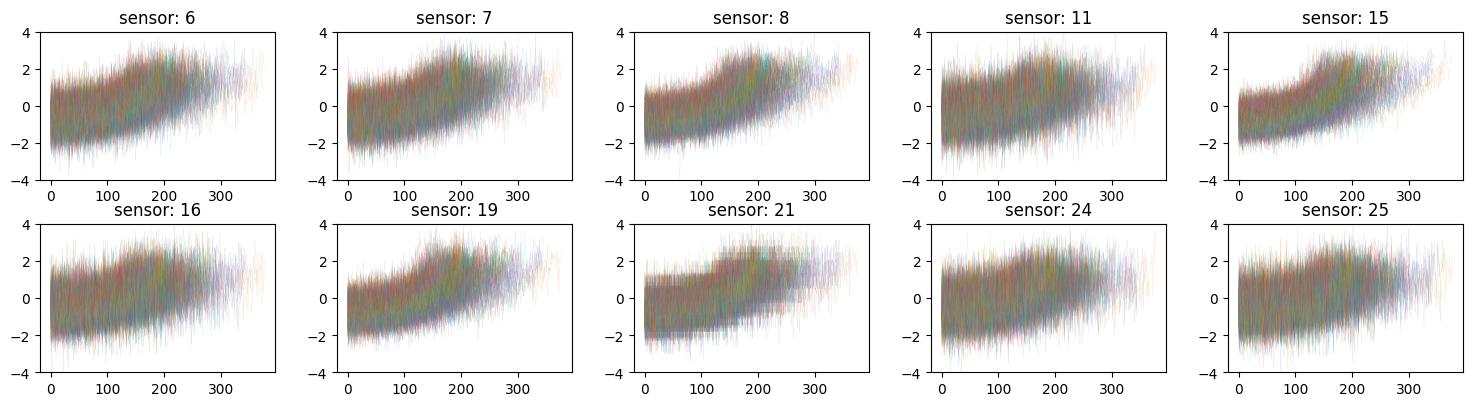

In [21]:
# show only useful sensors

figure, axis = plt.subplots(2,5)
figure.set_figheight(4)
figure.set_figwidth(15)
figure.tight_layout()

count=0
for s in [6,7,8,11,15,16,19,21,24,25]:

  for t in ref_traj.unique():
    traj_cluster = np.where(ref_traj == t)[0]
    axis[count//5, count%5].plot(s_traj_tn.iloc[traj_cluster,s-5].tolist(), linewidth=.05)# meaning of -5 => we deleted the unit num, cyle and op settings at the beginning
    axis[count//5, count%5].set_title(f"sensor: {s}")
  count+=1
# Defining custom  'ylim' values.
custom_ylim = (-4, 4)

# Setting the values for all axes.
plt.setp(axis, ylim=custom_ylim,)
plt.show()


In [36]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy import signal
import pandas as pd

def power_law(x, a, b, c):
    return a * np.power(x, b) + c

def smooth_power_law(data):
    x = np.arange(len(data))
    # Remove NaNs and infs
    mask = np.isfinite(data)
    if not np.any(mask):
        return np.zeros_like(data)  # Return zeros if all values are NaN or inf
    try:
        # Provide initial guess for parameters a, b, and c
        initial_guess = [1, 1, 1]
        popt, _ = curve_fit(power_law, x[mask], data[mask], p0=initial_guess, maxfev=10000)
        return power_law(x, *popt)
    except RuntimeError:
        # Return the original data if fitting fails
        return data

def ppmetrics(params):
    # Remove time variable if necessary
    for i in range(len(params)):
        if params[i].shape[1] == 2:
            params[i] = params[i][:, 1:]

    # Smooth Prognostic Parameters using 2-term power law function
    sparam = []
    for i in range(len(params)):
        sp = smooth_power_law(params[i].flatten())
        sparam.append(sp)

    # Monotonicity
    m = 30
    mpos = np.full(len(sparam), np.nan)
    mneg = np.full(len(sparam), np.nan)

    for i in range(len(sparam)):
        if len(sparam[i]) > 2 * m:
            n = len(sparam[i]) // m
        else:
            n = 3
            m = len(sparam[i]) // 3

        s = np.zeros(n)
        for j in range(n):
            y = sparam[i][int((j) * m):int((j + 1) * m)]
            x = np.arange(len(y))
            slope, _, _, _, _ = linregress(x, y)
            s[j] = slope

        mpos[i] = np.sum(s > 0) / n
        mneg[i] = np.sum(s < 0) / n

    monotonicity = np.nanmean(np.abs(mpos - mneg))

    # Prognosability
    failval = np.array([param[-1] for param in params])
    startval = np.array([param[0] for param in params])
    prognosability = np.exp(-np.std(failval) / np.mean(np.abs(startval - failval)))

    # Trendability
    # Re-sample data into %life instead of observations
    p = np.full((100, len(sparam)), np.nan)
    for i in range(len(sparam)):
        p[:, i] = signal.resample(sparam[i], 100)

    # Trendability is the minimum absolute correlation
    cc = np.corrcoef(p, rowvar=False)
    trendability = np.min(np.abs(cc[np.triu_indices(len(sparam), 1)]))

    return monotonicity, prognosability, trendability

# Example data loading (replace with actual loading logic)
# df_train = pd.read_csv("your_data_file.csv")  # Load your data file
# s_traj_n = df_train.iloc[:, 5:]  # Assuming sensor data starts from the 6th column

# Assuming df_train and s_traj_n are already defined
ref_traj = df_train.iloc[:, 0]  # First column as reference trajectory

def calculate_metrics(s_traj_n, ref_traj):
    results = []
    for s in range(5, s_traj_n.shape[1] + 5):
        params = []
        for t in ref_traj.unique():
            traj_cluster = np.where(ref_traj == t)[0]
            sensor_data = s_traj_n.iloc[traj_cluster, s - 5].to_numpy().reshape(-1, 1)
            params.append(sensor_data)

        monotonicity, prognosability, trendability = ppmetrics(params)
        results.append({
            'Sensor': s,
            'Monotonicity': monotonicity,
            'Prognosability': prognosability,
            'Trendability': trendability
        })
    return results

# Call the function with the actual data
results = calculate_metrics(s_traj_n, ref_traj)

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

# [6,7,8,11,15,16,19,21,24,25]

<ipython-input-36-9909c1857e7b>:8: RuntimeWarning: divide by zero encountered in power
  return a * np.power(x, b) + c
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:3193: RuntimeWarning: invalid value encountered in multiply
  Y[tuple(sl)] *= 2.


    Sensor  Monotonicity  Prognosability  Trendability
0        5      0.000000             NaN           NaN
1        6      1.000000        0.760700      0.737967
2        7      1.000000        0.742665      0.818189
3        8      1.000000        0.841880      0.896759
4        9      0.000000             NaN           NaN
5       10      0.999359        0.576114      0.262232
6       11      1.000000        0.560245      0.637868
7       12      0.984666        0.430482      0.000058
8       13      1.000000        0.315761      0.000067
9       14      0.935795             NaN           NaN
10      15      1.000000        0.869538      0.925333
11      16      1.000000        0.577912      0.658730
12      17      0.986346        0.424010      0.000695
13      18      1.000000        0.293027      0.000134
14      19      1.000000        0.753498      0.913214
15      20      0.858324             NaN           NaN
16      21      1.000000        0.770301      0.872488
17      22

In [41]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy import signal
import pandas as pd

def power_law(x, a, b, c):
    return a * np.power(x, b) + c

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def smooth_power_law(data):
    x = np.arange(len(data))
    # Remove NaNs and infs
    mask = np.isfinite(data)
    if not np.any(mask):
        return np.zeros_like(data)  # Return zeros if all values are NaN or inf
    if len(data[mask]) <= 3:
        return data  # Skip power law fitting if too few data points
    try:
        # Provide initial guess for parameters a, b, and c
        initial_guess = [1, 1, 1]
        popt, _ = curve_fit(power_law, x[mask], data[mask], p0=initial_guess, maxfev=10000)
        return power_law(x, *popt)
    except RuntimeError:
        # Return the original data if fitting fails
        return data

def ppmetrics(params):
    # Remove time variable if necessary
    for i in range(len(params)):
        if params[i].shape[1] == 2:
            params[i] = params[i][:, 1:]

    # Smooth Prognostic Parameters first with moving average then with power law
    sparam = []
    window_size = 25
    for i in range(len(params)):
        # Apply moving average
        ma_smoothed = moving_average(params[i].flatten(), window_size)
        # Apply power law smoothing to the moving average smoothed data
        sp = smooth_power_law(ma_smoothed)
        sparam.append(sp)

    # Monotonicity
    m = 30
    mpos = np.full(len(sparam), np.nan)
    mneg = np.full(len(sparam), np.nan)

    for i in range(len(sparam)):
        if len(sparam[i]) > 2 * m:
            n = len(sparam[i]) // m
        else:
            n = 3
            m = len(sparam[i]) // 3

        s = np.zeros(n)
        for j in range(n):
            y = sparam[i][int((j) * m):int((j + 1) * m)]
            x = np.arange(len(y))
            slope, _, _, _, _ = linregress(x, y)
            s[j] = slope

        mpos[i] = np.sum(s > 0) / n
        mneg[i] = np.sum(s < 0) / n

    monotonicity = np.nanmean(np.abs(mpos - mneg))

    # Prognosability
    failval = np.array([param[-1] for param in params])
    startval = np.array([param[0] for param in params])
    prognosability = np.exp(-np.std(failval) / np.mean(np.abs(startval - failval)))

    # Trendability
    # Re-sample data into %life instead of observations
    p = np.full((100, len(sparam)), np.nan)
    for i in range(len(sparam)):
        p[:, i] = signal.resample(sparam[i], 100)

    # Trendability is the minimum absolute correlation
    cc = np.corrcoef(p, rowvar=False)
    trendability = np.min(np.abs(cc[np.triu_indices(len(sparam), 1)]))

    return monotonicity, prognosability, trendability

# Example data loading (replace with actual loading logic)
# df_train = pd.read_csv("your_data_file.csv")  # Load your data file
# s_traj_n = df_train.iloc[:, 5:]  # Assuming sensor data starts from the 6th column

# Assuming df_train and s_traj_n are already defined
ref_traj = df_train.iloc[:, 0]  # First column as reference trajectory

def calculate_metrics(s_traj_n, ref_traj):
    results = []
    for s in range(5, s_traj_n.shape[1] + 5):
        params = []
        for t in ref_traj.unique():
            traj_cluster = np.where(ref_traj == t)[0]
            sensor_data = s_traj_n.iloc[traj_cluster, s - 5].to_numpy().reshape(-1, 1)
            params.append(sensor_data)

        monotonicity, prognosability, trendability = ppmetrics(params)
        results.append({
            'Sensor': s,
            'Monotonicity': monotonicity,
            'Prognosability': prognosability,
            'Trendability': trendability
        })
    return results

# Call the function with the actual data
results = calculate_metrics(s_traj_n, ref_traj)

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
<ipython-input-41-67d081380ecf>:8: RuntimeWarning: divide by zero encountered in power
  return a * np.power(x, b) + c
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:3193: RuntimeWarning: invalid value encountered in multiply
  Y[tuple(sl)] *= 2.
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


    Sensor  Monotonicity  Prognosability  Trendability
0        5      0.000000             NaN           NaN
1        6      1.000000        0.760700      0.730755
2        7      1.000000        0.742665      0.784901
3        8      1.000000        0.841880      0.897279
4        9      0.000000             NaN           NaN
5       10      1.000000        0.576114      0.364529
6       11      1.000000        0.560245      0.688644
7       12      0.999451        0.430482      0.189818
8       13      1.000000        0.315761      0.000305
9       14      0.205882             NaN           NaN
10      15      1.000000        0.869538      0.921313
11      16      1.000000        0.577912      0.489635
12      17      0.998901        0.424010      0.029192
13      18      1.000000        0.293027      0.000094
14      19      1.000000        0.753498      0.905672
15      20      0.000000             NaN           NaN
16      21      1.000000        0.770301      0.803778
17      22